<a href="https://colab.research.google.com/github/xuhu357/DataAnalysis/blob/master/ch07_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A4%80%EB%B9%84%ED%95%98%EA%B8%B0_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

In [0]:
data = {
    'Dave': 'dave@google.com',
    'Steve': 'steve@gmail.com',
    'Rob': 'rob@gmail.com',
    'Wes': np.nan
}

In [0]:
data = pd.Series(data)

In [5]:
data

Dave     dave@google.com
Steve    steve@gmail.com
Rob        rob@gmail.com
Wes                  NaN
dtype: object

In [6]:
data.isnull()

Dave     False
Steve    False
Rob      False
Wes       True
dtype: bool

문자열과 정규표현식 메소드는 data.map()함수를 사용해서 각 값에 적용할 수 있지만, NA값을 만나면, 실패.

이런 문제 해결하기 위해 Series에는 NA값을 건너뛰게 하는 간결한 문자열 처리 메소드 있다.
Series의 str속성을 이용.

In [7]:
# 'gmail' 이 포함되는지 여부 판단 

data.str.contains('gmail')

Dave     False
Steve     True
Rob       True
Wes        NaN
dtype: object

IGNORECASE와 같은 re 옵션과 함께 정규 표현식도 사용 가능

In [0]:
import re

In [0]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'

In [10]:
# pattern에 일치하는 모든 문자열 찾기

data.str.findall(pattern, flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Steve    [(steve, gmail, com)]
Rob        [(rob, gmail, com)]
Wes                        NaN
dtype: object

벡터화된 요소를 꺼내오는 몇가지 방법이 있는데, str.get을 이용하거나, str 속성의 색인을 이용하는 방법

In [11]:
matches = data.str.match(pattern, flags=re.IGNORECASE)

matches

Dave     True
Steve    True
Rob      True
Wes       NaN
dtype: object

In [0]:
matches = data.str.extract(pat=pattern, flags=re.IGNORECASE)

In [20]:
matches

,0,1,2
Dave,dave,google,com
Steve,steve,gmail,com
Rob,rob,gmail,com
Wes,NaN,NaN,NaN


In [22]:
matches.get(1)

Dave     google
Steve     gmail
Rob       gmail
Wes         NaN
Name: 1, dtype: object

In [23]:
matches[0]

Dave      dave
Steve    steve
Rob        rob
Wes        NaN
Name: 0, dtype: object

### 예제로 살펴보기

미국 농무부 음식 데이터 베이스

In [0]:
import json

In [26]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving foods-2011-10-03.json to foods-2011-10-03.json
User uploaded file "foods-2011-10-03.json" with length 31814355 bytes


In [27]:
db = json.load(open('foods-2011-10-03.json'))

len(db)

6636

In [28]:
# 각 데이터의 key를 살펴보기

db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [29]:
# nutrients의 값을 살펴보기

db[0]['nutrients'][0]

{'description': 'Protein',
 'group': 'Composition',
 'units': 'g',
 'value': 25.18}

In [30]:
nutrients = pd.DataFrame(db[0]['nutrients'])

nutrients[:7]

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00
5,Water,Composition,g,39.28
6,Energy,Energy,kJ,1573.00


In [31]:
nutrients.count()

description    162
group          162
units          162
value          162
dtype: int64

Dictionary List를 DataFrame으로 바꿀때 추출할 field 목록을 지정할 수 있다. 

음식 이름, 그룹, id 그리고 제조사만을 추출하자.

In [0]:
info_keys =['description', 'group', 'id', 'manufacturer']

info = pd.DataFrame(db, columns=info_keys)

In [48]:
info.head()

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [34]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
description     6636 non-null object
group           6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


value_counts()를 사용해서 음식 그룹의 분포를 확인해보자.

In [35]:
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Fast Foods                           365
Legumes and Legume Products          365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
Name: group, dtype: int64

분석 해볼것:
1.  각 음식의 영양소 정보를 거대한 테이블에 담기


> 음식영양소 리스트를 하나의 DataFrame으로 변환, 음식의 id를 위한 칼럼을 추가.

> DataFrame을 리스트에 추가

> 이 리스트를 concat을 사용해서 하나로 합친다.



In [0]:
nutrients =[]

for rec in db:
  fnuts = pd.DataFrame(rec['nutrients'])
  fnuts['id'] = rec['id']
  nutrients.append(fnuts)
  
nutrients = pd.concat(nutrients, ignore_index=True)

In [37]:
nutrients.describe()

,value,id
count,389355.000000,389355.000000
mean,66.074429,14951.226806
std,644.176571,8664.025821
min,0.000000,1008.000000
25%,0.040000,10047.000000
50%,0.784000,13898.000000
75%,9.000000,19019.000000
max,100000.000000,93600.000000


In [38]:
nutrients.head()

,description,group,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008


중복된 데이터를 제거해보자.

In [39]:
nutrients.duplicated().sum()

14179

In [0]:
nutrients = nutrients.drop_duplicates()

In [42]:
nutrients.head()

,description,group,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008


In [0]:
# 'group'과 'description'은 모두 dataframe 객체이므로 이름을 바꾸어서 알아보기 쉽도록 하자.

col_mapping = {
    'description':'food',
    'group': 'fgroup'
}

info = info.rename(columns=col_mapping, copy=False)

In [50]:
info.head()

,food,fgroup,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [51]:
# For nutrients

col_mapping = {
    'description': 'nutrient',
    'group': 'nutgroup'
}

nutrients = nutrients.rename(columns=col_mapping, copy=False)
nutrients.head()

,nutrient,nutgroup,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008


여기서 잠깐 정리하고 가자면, 

info에는 db에서의 'id', 'description', 'group', 'manufacturer' 등 네개 정보 포함, (nutrients는 X)
nutrients는 위에서 불포함된 nutrients 속성에 해당되는 데이터만 포함. 

그래서 두개를 합쳐서 살펴보기로 하는 거임.

In [52]:
db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [53]:
# info 칼럼은 위의 keys에서 description, group, id, manufacturer에 해당.
info.columns

Index(['food', 'fgroup', 'id', 'manufacturer'], dtype='object')

In [54]:
# nutrients는 db keys의 'nutrients'에 해당하는 데이터

nutrients.columns

Index(['nutrient', 'nutgroup', 'units', 'value', 'id'], dtype='object')

그럼 info와 nutrients를 합쳐서 완전체를 구성해보자.

In [55]:
ndata = pd.merge(nutrients, info, on='id', how='outer')

ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 375175
Data columns (total 8 columns):
nutrient        375176 non-null object
nutgroup        375176 non-null object
units           375176 non-null object
value           375176 non-null float64
id              375176 non-null int64
food            375176 non-null object
fgroup          375176 non-null object
manufacturer    293054 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 25.8+ MB


In [56]:
ndata.iloc[30000]

nutrient                                       Glycine
nutgroup                                   Amino Acids
units                                                g
value                                             0.04
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

In [57]:
ndata.head()

,nutrient,nutgroup,units,value,id,food,fgroup,manufacturer
0,Protein,Composition,g,25.18,1008,"Cheese, caraway",Dairy and Egg Products,
1,Total lipid (fat),Composition,g,29.20,1008,"Cheese, caraway",Dairy and Egg Products,
2,"Carbohydrate, by difference",Composition,g,3.06,1008,"Cheese, caraway",Dairy and Egg Products,
3,Ash,Other,g,3.28,1008,"Cheese, caraway",Dairy and Egg Products,
4,Energy,Energy,kcal,376.00,1008,"Cheese, caraway",Dairy and Egg Products,


시각화는 다른 chapter에서 상세하게 다루지만,

일단, 음식 그룹과 영양소의 종류별 중간 값을 그래프로 그려내면, 

In [0]:
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)

In [60]:
result.head()

nutrient          fgroup                           
Adjusted Protein  Sweets                               12.900
                  Vegetables and Vegetable Products     2.180
Alanine           Baby Foods                            0.085
                  Baked Products                        0.248
                  Beef Products                         1.550
Name: value, dtype: float64

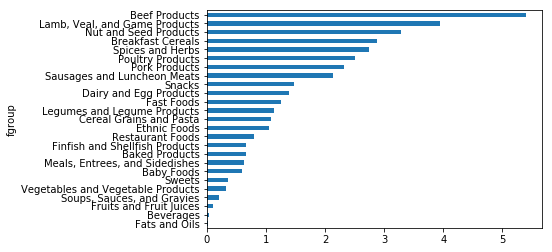

In [62]:
# Zinc, Zn 아연이 들어간 음식 그룹의 정황을 살펴보려면, 

result['Zinc, Zn'].sort_values().plot(kind='barh')

In [63]:
# 다른 index 도 확인하고 싶다면, 

result.index

MultiIndex(levels=[['Adjusted Protein', 'Alanine', 'Alcohol, ethyl', 'Arginine', 'Ash', 'Aspartic acid', 'Beta-sitosterol', 'Betaine', 'Caffeine', 'Calcium, Ca', 'Campesterol', 'Carbohydrate, by difference', 'Carotene, alpha', 'Carotene, beta', 'Cholesterol', 'Choline, total', 'Copper, Cu', 'Cryptoxanthin, beta', 'Cystine', 'Dihydrophylloquinone', 'Energy', 'Fatty acids, total monounsaturated', 'Fatty acids, total polyunsaturated', 'Fatty acids, total saturated', 'Fatty acids, total trans', 'Fatty acids, total trans-monoenoic', 'Fatty acids, total trans-polyenoic', 'Fiber, total dietary', 'Fluoride, F', 'Folate, DFE', 'Folate, food', 'Folate, total', 'Folic acid', 'Fructose', 'Galactose', 'Glucose (dextrose)', 'Glutamic acid', 'Glycine', 'Histidine', 'Hydroxyproline', 'Iron, Fe', 'Isoleucine', 'Lactose', 'Leucine', 'Lutein + zeaxanthin', 'Lycopene', 'Lysine', 'Magnesium, Mg', 'Maltose', 'Manganese, Mn', 'Menaquinone-4', 'Methionine', 'Niacin', 'Pantothenic acid', 'Phenylalanine', 'Phos

In [64]:
# zinc, zn 상세 정황을 보려면,
result['Zinc, Zn']

fgroup
Baby Foods                           0.590
Baked Products                       0.660
Beef Products                        5.390
Beverages                            0.040
Breakfast Cereals                    2.885
Cereal Grains and Pasta              1.090
Dairy and Egg Products               1.390
Ethnic Foods                         1.045
Fast Foods                           1.250
Fats and Oils                        0.020
Finfish and Shellfish Products       0.670
Fruits and Fruit Juices              0.100
Lamb, Veal, and Game Products        3.940
Legumes and Legume Products          1.140
Meals, Entrees, and Sidedishes       0.630
Nut and Seed Products                3.290
Pork Products                        2.320
Poultry Products                     2.500
Restaurant Foods                     0.800
Sausages and Luncheon Meats          2.130
Snacks                               1.470
Soups, Sauces, and Gravies           0.200
Spices and Herbs                     2.750
Swee

좀 더 응용해본다면, 각 영양소가 어떤 음식에 가장 많이 들어있는지 확인 가능

In [0]:
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])

In [0]:
get_maximum = lambda x: x.xs(x.value.idxmax())

In [0]:
get_minimum = lambda x: x.xs(x.value.idxmin())

In [72]:
ndata.head()

,nutrient,nutgroup,units,value,id,food,fgroup,manufacturer
0,Protein,Composition,g,25.18,1008,"Cheese, caraway",Dairy and Egg Products,
1,Total lipid (fat),Composition,g,29.20,1008,"Cheese, caraway",Dairy and Egg Products,
2,"Carbohydrate, by difference",Composition,g,3.06,1008,"Cheese, caraway",Dairy and Egg Products,
3,Ash,Other,g,3.28,1008,"Cheese, caraway",Dairy and Egg Products,
4,Energy,Energy,kcal,376.00,1008,"Cheese, caraway",Dairy and Egg Products,


In [0]:
max_food = by_nutrient.apply(get_maximum)[['value', 'food']]

In [0]:
# make the food a little smaller 
max_food.food = max_food.food.str[:50]

In [75]:
max_food

value  \
nutgroup    nutrient                                     
Amino Acids Alanine                              8.009   
            Arginine                             7.436   
            Aspartic acid                       10.203   
            Cystine                              1.307   
            Glutamic acid                       17.452   
            Glycine                             19.049   
            Histidine                            2.999   
            Hydroxyproline                       0.803   
            Isoleucine                           4.300   
            Leucine                              7.200   
            Lysine                               6.690   
            Methionine                           1.859   
            Phenylalanine                        4.600   
            Proline                             12.295   
            Serine                               4.600   
            Threonine                            3.300   
            Tryptophan                           1.600   
            Tyrosine                             3.300   
            Valine                               4.500   
Composition Adjusted Protein                    12.900   
            Carbohydrate, by difference        100.000   
            Fiber, total dietary                79.000   
            Protein                             88.320   
            Sugars, total                       99.800   
            Total lipid (fat)                  100.000   
            Water                              100.000   
Elements    Calcium, Ca                       7364.000   
            Copper, Cu                          15.050   
            Fluoride, F                        584.000   
            Iron, Fe                            87.470   
...                                                ...   
Vitamins    Cryptoxanthin, beta               6186.000   
            Dihydrophylloquinone               103.800   
            Folate, DFE                       2630.000   
            Folate, food                      2340.000   
            Folate, total                     2340.000   
            Folic acid                        1538.000   
            Lutein + zeaxanthin              39550.000   
            Lycopene                         46260.000   
            Menaquinone-4                       33.200   
            Niacin                              97.000   
            Pantothenic acid                    35.000   
            Retinol                          30000.000   
            Riboflavin                          14.300   
            Thiamin                             20.000   
            Tocopherol, beta                     6.490   
            Tocopherol, delta                   30.880   
            Tocopherol, gamma                  100.880   
            Vitamin A, IU                   100000.000   
            Vitamin A, RAE                   30000.000   
            Vitamin B-12                        98.890   
            Vitamin B-12, added                 24.000   
            Vitamin B-6                         12.000   
            Vitamin C, total ascorbic acid    2400.000   
            Vitamin D                        10000.000   
            Vitamin D (D2 + D3)                250.000   
            Vitamin D2 (ergocalciferol)         28.100   
            Vitamin D3 (cholecalciferol)        27.400   
            Vitamin E (alpha-tocopherol)       149.400   
            Vitamin E, added                    46.550   
            Vitamin K (phylloquinone)         1714.500   

                                                                                         food  
nutgroup    nutrient                                                                           
Amino Acids Alanine                                         Gelatins, dry powder, unsweetened  
            Arginine                                             Seeds, sesame flour, low-fat  
          

In [76]:
max_food.loc['Amino Acids']['food']

nutrient
Alanine                           Gelatins, dry powder, unsweetened
Arginine                               Seeds, sesame flour, low-fat
Aspartic acid                                   Soy protein isolate
Cystine                Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                   Soy protein isolate
Glycine                           Gelatins, dry powder, unsweetened
Histidine                Whale, beluga, meat, dried (Alaska Native)
Hydroxyproline    KENTUCKY FRIED CHICKEN, Fried Chicken, ORIGINA...
Isoleucine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Leucine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Lysine            Seal, bearded (Oogruk), meat, dried (Alaska Na...
Methionine                    Fish, cod, Atlantic, dried and salted
Phenylalanine     Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Proline                           Gelatins, dry powder, unsweetened
Serine            Soy protein isolate, 

2019.05.01, 여기까지 하면, 전반적으로 분석을 위한 데이터 준비 작업을 살펴보기를 끝냄. 

다음장부터는 분석에 반드시 필요한 visualization에 대해서 살펴보도록 함. 